<font size=7> Latencies - CA1 Analysis

**Results**

Good Connections: (37, 81), (76, 66), (79, 103), (121, 103), (130, 9), (138, 81)

# Set Up Notebook

import stuff

In [ ]:
import pickle

load source code

load source code

In [1]:
%run Latencies_Source_Code.ipynb

read data function

In [5]:
import io
import zipfile
from typing import List, Tuple

def read_phy_files(path: str, fs=20000.0):
    """
    :param path: a s3 or local path to a zip of phy files.
    :return: SpikeData class with a list of spike time lists and neuron_data.
            neuron_data = {0: neuron_dict, 1: config_dict}
            neuron_dict = {"new_cluster_id": {"channel": c, "position": (x, y),
                            "amplitudes": [a0, a1, an], "template": [t0, t1, tn],
                            "neighbor_channels": [c0, c1, cn],
                            "neighbor_positions": [(x0, y0), (x1, y1), (xn,yn)],
                            "neighbor_templates": [[t00, t01, t0n], [tn0, tn1, tnn]}}
            config_dict = {chn: pos}
    """
    assert path[-3:] == 'zip', 'Only zip files supported!'
    import braingeneers.utils.smart_open_braingeneers as smart_open
    with smart_open.open(path, 'rb') as f0:
        f = io.BytesIO(f0.read())

        with zipfile.ZipFile(f, 'r') as f_zip:
            assert 'params.py' in f_zip.namelist(), "Wrong spike sorting output."
            with io.TextIOWrapper(f_zip.open('params.py'), encoding='utf-8') as params:
                for line in params:
                    if "sample_rate" in line:
                        fs = float(line.split()[-1])
            clusters = np.load(f_zip.open('spike_clusters.npy')).squeeze()
            templates = np.load(f_zip.open('templates.npy'))  # (cluster_id, samples, channel_id)
            channels = np.load(f_zip.open('channel_map.npy')).squeeze()
            templates_w = np.load(f_zip.open('templates.npy'))
            wmi = np.load(f_zip.open('whitening_mat_inv.npy'))
            spike_templates = np.load(f_zip.open('spike_templates.npy')).squeeze()
            spike_times = np.load(f_zip.open('spike_times.npy')).squeeze() / fs * 1e3  # in ms
            positions = np.load(f_zip.open('channel_positions.npy'))
            amplitudes = np.load(f_zip.open("amplitudes.npy")).squeeze()
            if 'cluster_info.tsv' in f_zip.namelist():
                cluster_info = pd.read_csv(f_zip.open('cluster_info.tsv'), sep='\t')
                cluster_id = np.array(cluster_info['cluster_id'])
                # select clusters using curation label, remove units labeled as "noise"
                # find the best channel by amplitude
                labeled_clusters = cluster_id[cluster_info['group'] != "noise"]
            else:
                labeled_clusters = np.unique(clusters)

    df = pd.DataFrame({"clusters": clusters, "spikeTimes": spike_times, "amplitudes": amplitudes})
    cluster_agg = df.groupby("clusters").agg({"spikeTimes": lambda x: list(x),
                                              "amplitudes": lambda x: list(x)})
    cluster_agg = cluster_agg[cluster_agg.index.isin(labeled_clusters)]

    cls_temp = dict(zip(clusters, spike_templates))
    neuron_dict = dict.fromkeys(np.arange(len(labeled_clusters)), None)

    # un-whitten the templates before finding the best channel
    templates = np.dot(templates_w, wmi)

    neuron_attributes = []
    for i in range(len(labeled_clusters)):
        c = labeled_clusters[i]
        temp = templates[cls_temp[c]]
        amp = np.max(temp, axis=0) - np.min(temp, axis=0)
        sorted_idx = [ind for _, ind in sorted(zip(amp, np.arange(len(amp))))]
        nbgh_chan_idx = sorted_idx[::-1][:12]
        nbgh_temps = temp.transpose()[nbgh_chan_idx]
        best_chan_temp = nbgh_temps[0]
        nbgh_channels = channels[nbgh_chan_idx]
        nbgh_postions = [tuple(positions[idx]) for idx in nbgh_chan_idx]
        best_channel = nbgh_channels[0]
        best_position = nbgh_postions[0]
        # neighbor_templates = dict(zip(nbgh_postions, nbgh_temps))
        cls_amp = cluster_agg["amplitudes"][c]
        neuron_dict[i] = {"cluster_id": c, "channel": best_channel, "position": best_position,
                          "amplitudes": cls_amp, "template": best_chan_temp,
                          "neighbor_channels": nbgh_channels, "neighbor_positions": nbgh_postions,
                          "neighbor_templates": nbgh_temps}
        neuron_attributes.append(
            NeuronAttributes(
                cluster_id=c,
                channel=best_channel,
                position=best_position,
                amplitudes=cluster_agg["amplitudes"][c],
                template=best_chan_temp,
                templates=templates[cls_temp[c]].T,
                label=cluster_info['group'][cluster_info['cluster_id'] == c].values[0],
                neighbor_channels=channels[nbgh_chan_idx],
                neighbor_positions=[tuple(positions[idx]) for idx in nbgh_chan_idx],
                neighbor_templates=[templates[cls_temp[c]].T[n] for n in nbgh_chan_idx]
            )
        )

    config_dict = dict(zip(channels, positions))
    neuron_data = {0: neuron_dict}
    metadata = {0: config_dict}
    spikedata = SpikeData(list(cluster_agg["spikeTimes"]), neuron_data=neuron_data, metadata=metadata, neuron_attributes=neuron_attributes)
    return spikedata

class NeuronAttributes:
    cluster_id: int
    channel: np.ndarray
    position: Tuple[float, float]
    amplitudes: List[float]
    template: np.ndarray
    templates: np.ndarray
    label: str

    # These lists are the same length and correspond to each other
    neighbor_channels: np.ndarray
    neighbor_positions: List[Tuple[float, float]]
    neighbor_templates: List[np.ndarray]

    def __init__(self, *args, **kwargs):
        self.cluster_id = kwargs.pop("cluster_id")
        self.channel = kwargs.pop("channel")
        self.position = kwargs.pop("position")
        self.amplitudes = kwargs.pop("amplitudes")
        self.template = kwargs.pop("template")
        self.templates = kwargs.pop("templates")
        self.label = kwargs.pop("label")
        self.neighbor_channels = kwargs.pop("neighbor_channels")
        self.neighbor_positions = kwargs.pop("neighbor_positions")
        self.neighbor_templates = kwargs.pop("neighbor_templates")
        for key, value in kwargs.items():
            setattr(self, key, value)

    def add_attribute(self, key, value):
        setattr(self, key, value)

    def list_attributes(self):
        return [attr for attr in dir(self) if not attr.startswith('__') and not callable(getattr(self, attr))]


load data

In [12]:
sd = read_phy_files(f"/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3_28_hckcr1_chip16835_plated34_2_rec4_2_curated.zip") 


In [13]:
sd.N

140

load latencies, as curated by Tom

In [4]:
file = open('/home/jovyan/work/Human_Hippocampus/data/saved_latencies/2023-04-02-e-hc328.pkl', 'rb')
all_latencies = pickle.load(file)
file.close()

In [5]:
pairs_lates_directed = all_latencies["pairs_lates"]

In [6]:
len(pairs_lates_directed)

54

clean latencies

In [7]:
pairs_lates_clean = {}
for pair, lates_i in pairs_lates_directed.items():
    percent_pos = np.sum(lates_i > 0) / len(lates_i)
    if percent_pos > .65:
        pairs_lates_clean[pair]=lates_i

In [8]:
pairs_lates_list = list(pairs_lates_clean.items())

# Make Plots

## Grouped Latencies

Plot all latencies curated by Tom

/tmp/ipykernel_940399/3022611541.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_940399/3022611541.py:51: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(


27


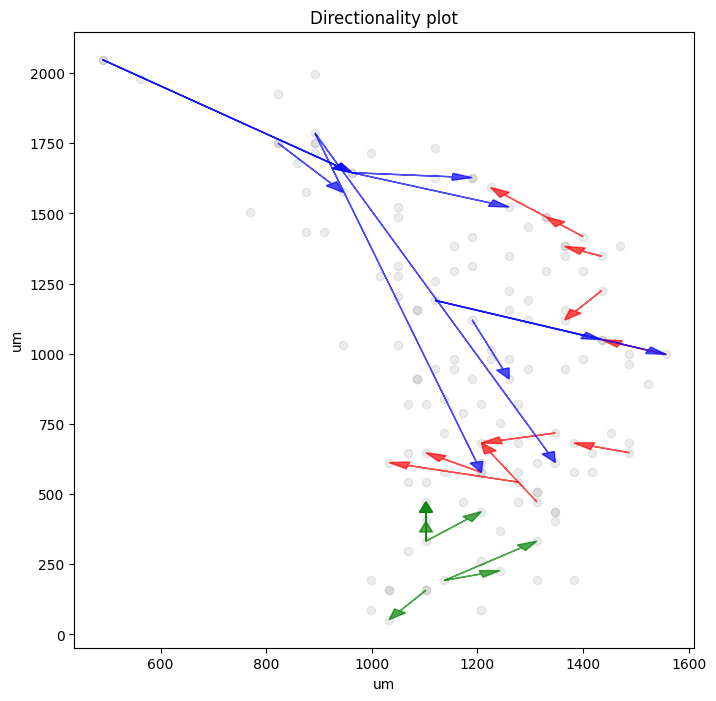

In [9]:
plotLatencyLayoutGroups(sd, pairs_lates_clean )

## Individual Pair Analysis

In [9]:
isis = sd.interspike_intervals()
firing_rates = calculate_mean_firing_rates(sd)
sttc = sd.spike_time_tilings()

In [10]:
interact_manual( plotLatencyPairAnalysis, num=(0,(len(pairs_lates_clean)-1) ))

interactive(children=(IntSlider(value=13, description='num', max=26), Button(description='Run Interact', style…

<function __main__.plotLatencyPairAnalysis(num)>

# Clean Latency by ms

Here we only keep the latencies above whose median latency is between 2-10ms

In [11]:
pairs_lates_clean2 = {}
for pair, lates_i in pairs_lates_clean.items():
    if abs(np.median(lates_i))>1:
        pairs_lates_clean2[pair]=lates_i

In [27]:
pairs_lates_clean2.keys()

dict_keys([(37, 81), (76, 66), (79, 103), (121, 103), (130, 9), (138, 81)])

/tmp/ipykernel_943595/3022611541.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_943595/3022611541.py:51: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(


6


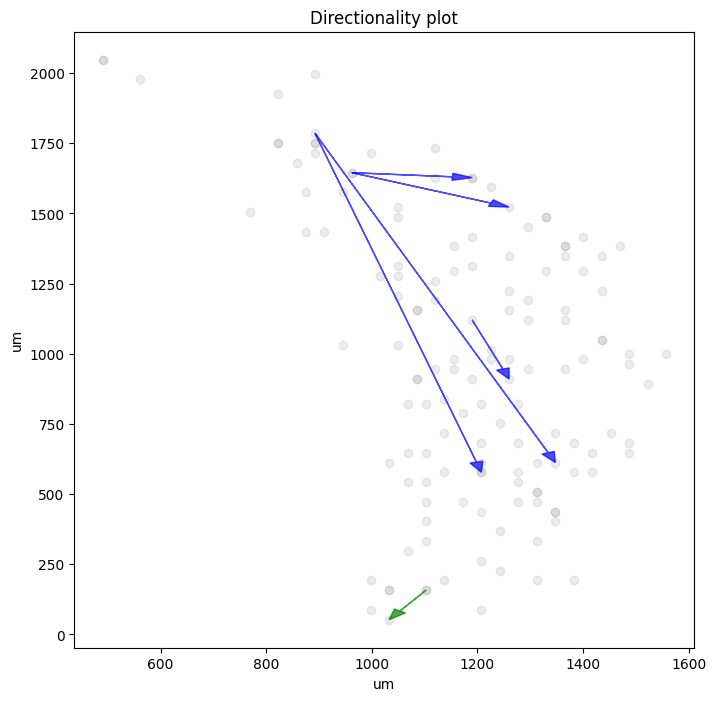

In [12]:
plotLatencyLayoutGroups(sd, pairs_lates_clean2 )

# View STTC

In [13]:
sttc_clean = []
for key in pairs_lates_clean.keys():
    sttc_clean.append(sttc[key[0]][key[1]])

(array([5., 4., 1., 2., 2., 0., 3., 3., 3., 4.]),
 array([0.21866745, 0.2968007 , 0.37493396, 0.45306721, 0.53120047,
        0.60933372, 0.68746698, 0.76560023, 0.84373349, 0.92186674,
        1.        ]),
 <BarContainer object of 10 artists>)

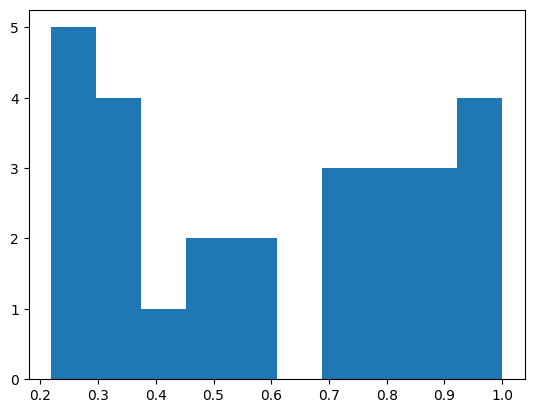

In [14]:
plt.hist(sttc_clean)

In [26]:
print("Total number of directed pairs --", len(sttc_clean))

Total number of directed pairs -- 27


In [20]:
print("minimum STTC from directed pairs: ",min(sttc_clean) )

minimum STTC from directed pairs:  0.21866744872390137


In [25]:
print( "Total STTC's above 0.2 --",np.sum(sttc>.2)/2 )

Total STTC's above 0.2 -- 141.0


# General Latency Pair Analysis

In [ ]:
def plotLatencyPairAnalysis(num):
    
    import warnings
    warnings.filterwarnings("ignore")

    # Layout Plot
    pairs_lates_list = list(pairs_lates_clean.items())
    to_graph = {pairs_lates_list[num][0]:pairs_lates_list[num][1]}
    plotLatencyPairFootprint(sd,to_graph)
    
    # Summary Stats
    start_i = pairs_lates_list[num][0][0]
    end_i = pairs_lates_list[num][0][1]
    latencies = pairs_lates_list[num][1]
    
    print( "Number of Latencies", len(latencies) )
    print( "Mean Latency", round(np.mean(latencies), 3) )
    print( "Median Latency", round(np.median(latencies), 3) )
    #print( "Latency Probability", {round(100*(len(lates_filtered)/len(lates_raw)))})
    print("STTC", sttc[start_i][end_i])
    print("Diptest P-val", round( diptest.diptest(latencies)[1] , 3) )
    print( "Latency Probability", round(len(latencies)/len(sd.train[start_i]), 3) )
    print(".")
    print( "Sender Neuron", start_i)
    print( "Sender   Firing Rate", round(firing_rates[start_i], 3) )
    print(".")
    print("Receiver Neuron", end_i)
    print( "Receiver Firing Rate", round(firing_rates[end_i], 3) )
    
    # Plot other graphs
    figs, plots = plt.subplots(nrows=3,ncols=2,figsize=(14,10))

    mean_latency = np.mean(latencies)     # Get mean and SD
    std_latency = np.std(latencies)
    cutoff = 2 * std_latency           # remove outliers
    lates_filtered = [latency for latency in latencies if abs(latency - mean_latency) <= cutoff]
    plots[0,0].hist(lates_filtered, bins=12, alpha=0.7, label='Latency')
    plots[0,0].axvline(mean_latency, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plots[0,0].axvline(mean_latency - std_latency, color='green', linestyle='dashed', linewidth=2, label='Std -')
    plots[0,0].axvline(mean_latency + std_latency, color='green', linestyle='dashed', linewidth=2, label='Std +')
    plots[0,0].axvline(0, color='black', linestyle='dashed', linewidth=0.5, label='Std +')
    plots[0,0].set_xlim(-1*(abs(mean_latency)+cutoff), abs(mean_latency) + cutoff) 
    plots[0,0].set_xlabel("Latency (ms)")
    plots[0,0].set_ylabel("Count")
    plots[0,0].set_title(f"Fancy Latency Histogram")
    plots[0,0].legend()

    plots[0,1].hist(latencies, bins=12)
    plots[0,1].set_title("Latency Histogram")
    plots[0,1].set_xlabel("Latency (ms)")
    plots[0,1].set_ylabel("Count")

    plots[1,0].hist(isis[start_i], bins=50);
    plots[1,0].set_title("Sender ISI")
    plots[1,0].set_xlabel("Time bin(ms)")
    plots[1,0].set_ylabel("ISI count")

    plots[1,1].hist(isis[end_i], bins=50);
    plots[1,1].set_title("Receiver ISI")
    plots[1,1].set_xlabel("Time bin(ms)")
    plots[1,1].set_ylabel("ISI count")
    
    
    plots[2,0].plot( sd.neuron_data[0][start_i]["template"] )
    plots[2,0].set_title("Sender Spike Waveform")
    plots[2,0].set_xlabel("")
    plots[2,0].set_ylabel("")
    
    plots[2,1].plot( sd.neuron_data[0][end_i]["template"] )
    plots[2,1].set_title("Receiver Spike Waveform")
    plots[2,1].set_xlabel("")
    plots[2,1].set_ylabel("")
    

# <font color="red"> Sury Footprint Code  - Not Done

In [28]:
checkit=sd.neuron_attributes[0]

In [29]:
checkit

NeuronAttributes(cluster_id=0, channel=0, position=(770.0, 1505.0), amplitudes=[24.698925018310547, 22.395610809326172, 19.42011833190918, 26.763961791992188, 19.278779983520508, 25.235591888427734, 21.036766052246094, 26.958547592163086, 20.22342872619629, 21.332565307617188, 20.236835479736328, 23.363849639892578, 24.62937355041504, 25.298574447631836, 24.968503952026367, 21.891164779663086, 22.66792106628418, 22.511791229248047, 19.495357513427734, 19.1392822265625, 23.136859893798828, 20.45022201538086, 24.182636260986328, 24.028135299682617, 19.083162307739258, 20.937353134155273, 25.734371185302734, 22.939176559448242, 20.742177963256836, 22.911893844604492, 21.04637336730957, 24.3459415435791, 18.578739166259766, 23.01606559753418, 16.69774055480957, 20.666006088256836, 22.349868774414062, 20.129724502563477, 18.53731918334961, 15.519327163696289, 17.141605377197266, 19.73779296875, 21.73084831237793, 18.985408782958984, 26.753620147705078, 23.182445526123047, 15.879393577575684

In [35]:
sd.neuron_data[0][0]["neighbor_templates"].shape

(715, 82)

In [12]:
def plot_inset(axs, k, ch, position, temp_chs, temp_pos, templates, filename, nelec=2, ylim_margin=0):
    axs.set_title(f"{filename} cluster {k} channel {ch} {position}")
    assert len(temp_chs) == len(temp_pos) == len(templates), "Input length should be the same!"
    nums = len(temp_chs)
    pitch = 17.5
    axs.scatter(position[0], position[1], linewidth=10, alpha=0.2, color='grey')
    axs.text(position[0], position[1], str(position), color="g", fontsize=12)
    # set same scaling to the insets
    index = temp_chs.index(ch)
    ylim_min = min(templates[index])
    ylim_max = max(templates[index])
    # choose channels that are close to the center channel
    for i in range(nums):
        chn_pos = temp_pos[i]
        if position[0] - nelec * pitch <= chn_pos[0] <= position[0] + nelec * pitch \
                and position[1] - nelec * pitch <= chn_pos[1] <= position[1] + nelec * pitch:
            # axs.scatter(chn_pos[0], chn_pos[1], color='w')
            axin = axs.inset_axes([chn_pos[0]-5, chn_pos[1]-5, 15, 20], transform=axs.transData)
            axin.plot(templates[i], color='k', linewidth=2, alpha=0.7)
            axin.set_ylim([ylim_min - ylim_margin, ylim_max + ylim_margin])
            axin.set_axis_off()
    # axs.legend(loc="upper right", fontsize=12)
    # axs.xaxis.set_visible(False)
    # axs.yaxis.set_visible(False)
    axs.set_xlim(position[0]-1.5*nelec*pitch, position[0]+1.5*nelec*pitch)
    axs.set_ylim(position[1]-1.5*nelec*pitch, position[1]+1.5*nelec*pitch)
    axs.invert_yaxis()
    return axs

In [31]:
data= sd.neuron_data[0][3]

/tmp/ipykernel_940399/143676880.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  data= sd.neuron_data[0][3]


AssertionError: Input length should be the same!

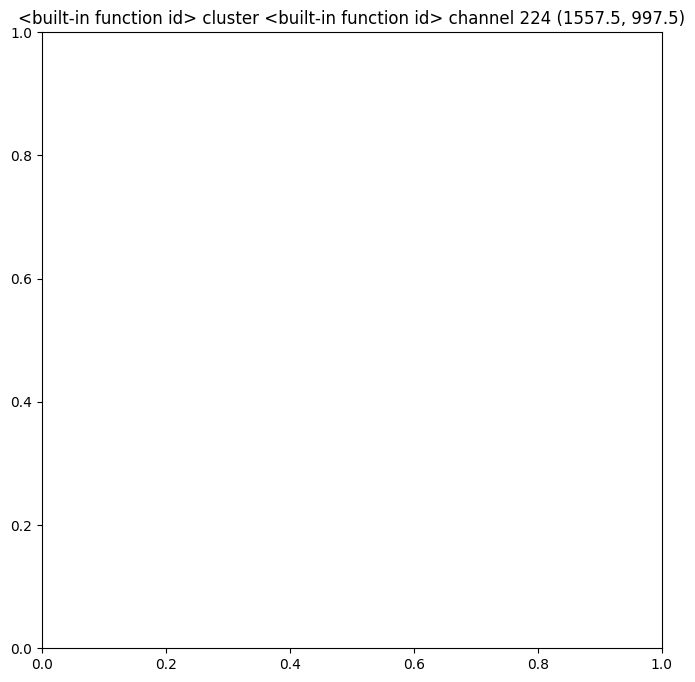

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plot_inset(axs, k=id, ch=data["channel"],
                        position=data["position"],
                        temp_chs=list(data["neighbor_channels"]),
                        temp_pos=data["neighbor_positions"],
                        templates=data["neighbor_templates"],
                        filename=f"{id}", nelec=2)

In [42]:
list(data["neighbor_channels"])

[165, 254, 21, 218, 263, 33, 198, 119, 53, 17, 135, 412]

In [33]:
len(temp_chs)

12

In [39]:
data["neighbor_positions"]

[(1015.0, 1277.5),
 (1015.0, 1347.5),
 (1015.0, 1312.5),
 (980.0, 1277.5),
 (980.0, 1312.5),
 (1050.0, 1277.5),
 (1050.0, 1347.5),
 (1050.0, 1312.5),
 (1050.0, 1242.5),
 (1085.0, 1312.5),
 (1050.0, 1382.5),
 (1085.0, 1347.5)]

In [50]:
data["neighbor_templates"]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.84090842e-12, -3.09405926e-12, -6.42157296e-12],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.95855338e-12, -3.23479484e-12, -6.72801738e-12],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.04293581e-12, -3.31323608e-12, -6.87548912e-12],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.37133747e-03, -2.78732520e-03, -5.65304965e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.11709095e-03, -2.64269073e-03, -5.46379307e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.42702971e-03, -3.59401221e-03, -6.98718032e-03]])

In [36]:
data["neighbor_templates"].shape

(715, 82)

In [49]:
data['template']

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.12510793e-12,  2.16970863e-11,  1.86856084e-11,
        2.15818343e-11,  2.39873624e-11,  2.47391890e-11,  2.78036411e-11,
        2.91410464e-11,  2.86023466e-11,  3.07585520e-11,  3.33887459e-11,
        3.22038877e-11,  3.42848004e-11,  3.99690929e-11,  3.83495430e-11,
        4.34058384e-11,  5.96726269e-11,  2.71750696e-11, -1.13798157e-10,
       -2.88927432e-10, -3.14991613e-10, -1.90847094e-10, -8.53636300e-11,
       -2.51273663e-11,  1.28387058e-11,  2.68547243e-11,  3.41376752e-11,
        2.90702418e-11,  2.60139744e-11,  2.13010401e-11,  1.59292337e-11,
        1.29150905e-11,  

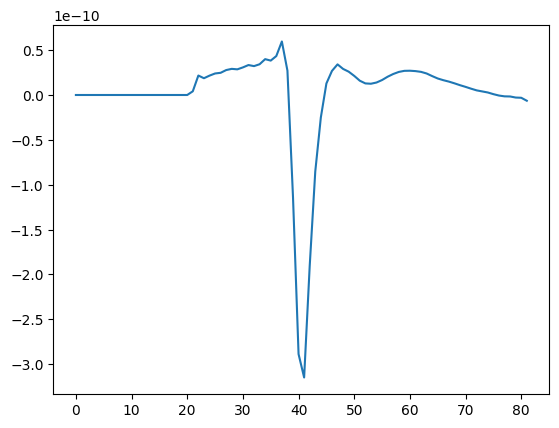

In [46]:


plt.plot(data['template'] )

/tmp/ipykernel_940399/3042750079.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sd.neuron_data[0][3]["template"]


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.12510793e-12,  2.16970863e-11,  1.86856084e-11,
        2.15818343e-11,  2.39873624e-11,  2.47391890e-11,  2.78036411e-11,
        2.91410464e-11,  2.86023466e-11,  3.07585520e-11,  3.33887459e-11,
        3.22038877e-11,  3.42848004e-11,  3.99690929e-11,  3.83495430e-11,
        4.34058384e-11,  5.96726269e-11,  2.71750696e-11, -1.13798157e-10,
       -2.88927432e-10, -3.14991613e-10, -1.90847094e-10, -8.53636300e-11,
       -2.51273663e-11,  1.28387058e-11,  2.68547243e-11,  3.41376752e-11,
        2.90702418e-11,  2.60139744e-11,  2.13010401e-11,  1.59292337e-11,
        1.29150905e-11,  

In [37]:
data

{'cluster_id': 3,
 'channel': 165,
 'position': (1015.0, 1277.5),
 'amplitudes': [20.406145095825195,
  22.812875747680664,
  20.809246063232422,
  21.1033878326416,
  21.92420196533203,
  20.592599868774414,
  22.432586669921875,
  21.350122451782227,
  20.862245559692383,
  22.27748680114746,
  22.106035232543945,
  20.747154235839844,
  25.55288314819336,
  22.02715301513672,
  21.100419998168945,
  23.60101890563965,
  19.99726676940918,
  22.531204223632812,
  24.265216827392578,
  20.76258087158203,
  20.450368881225586,
  22.507816314697266,
  21.114120483398438,
  18.968345642089844,
  21.5631160736084,
  21.0008544921875,
  23.11899185180664,
  23.965288162231445,
  20.007793426513672,
  22.01596450805664,
  20.59709358215332,
  17.10990333557129,
  19.805618286132812,
  21.60978889465332,
  17.481853485107422,
  22.95480728149414,
  22.408187866210938,
  18.66384506225586,
  20.195411682128906,
  21.95633888244629,
  22.489301681518555,
  22.15978240966797,
  19.1104564666748

In [ ]:
sd.neuron_data["1"]